In [1]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import albumentations as A
import torch
from albumentations.pytorch import ToTensorV2
from timm.data.mixup import Mixup
from torchvision import transforms

/home/monarch/ghq/github.com/bhdai/paddy_doctor/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../data/train.csv")
labels = df['label'].unique()
class_map = {l: i for i, l in enumerate(labels)}
class_map

{'bacterial_leaf_blight': 0,
 'bacterial_leaf_streak': 1,
 'bacterial_panicle_blight': 2,
 'blast': 3,
 'brown_spot': 4,
 'dead_heart': 5,
 'downy_mildew': 6,
 'hispa': 7,
 'normal': 8,
 'tungro': 9}

In [3]:
image_size = 224

In [4]:
transformations = [
    ('Horizontal Flip', A.HorizontalFlip(p=1.0)),
    ('Vertical Flip', A.VerticalFlip(p=1.0)),
    ('Affine', A.Affine(
        scale=(0.9, 1.1),
        translate_percent=(-0.0625, 0.0625),
        rotate=(-45, 45),
        p=1.0
    )),
    ('RandomBrightnessContrast', A.RandomBrightnessContrast(p=1.0)),
    ('RandomGamma', A.RandomGamma(p=1.0)),
    ('Resize', A.Resize(height=image_size, width=image_size)),
    ('Normalize', A.Compose([
        A.Normalize(),
        ToTensorV2()
    ]))
]

In [5]:
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    tensor = tensor.clone()
    tensor = tensor.permute(1, 2, 0).numpy()
    for i in range(3):
        tensor[:, :, i] = tensor[:, :, i] * std[i] + mean[i]
    return np.clip(tensor, 0, 1)

In [6]:
dataset_path = '../data/train_images'

In [7]:
label_folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
label_folders

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [8]:
random_label = random.choice(label_folders)
label_path = os.path.join(dataset_path, random_label)
{random_label: label_path}

{'normal': '../data/train_images/normal'}

In [9]:
image_files = [f for f in os.listdir(label_path) if f.endswith('.jpg')]
image_files[:5]

['100002.jpg', '100007.jpg', '100018.jpg', '100025.jpg', '100044.jpg']

In [10]:
random_image = random.choice(image_files)
image_path = os.path.join(label_path, random_image)
image_path

'../data/train_images/normal/107581.jpg'

In [11]:
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

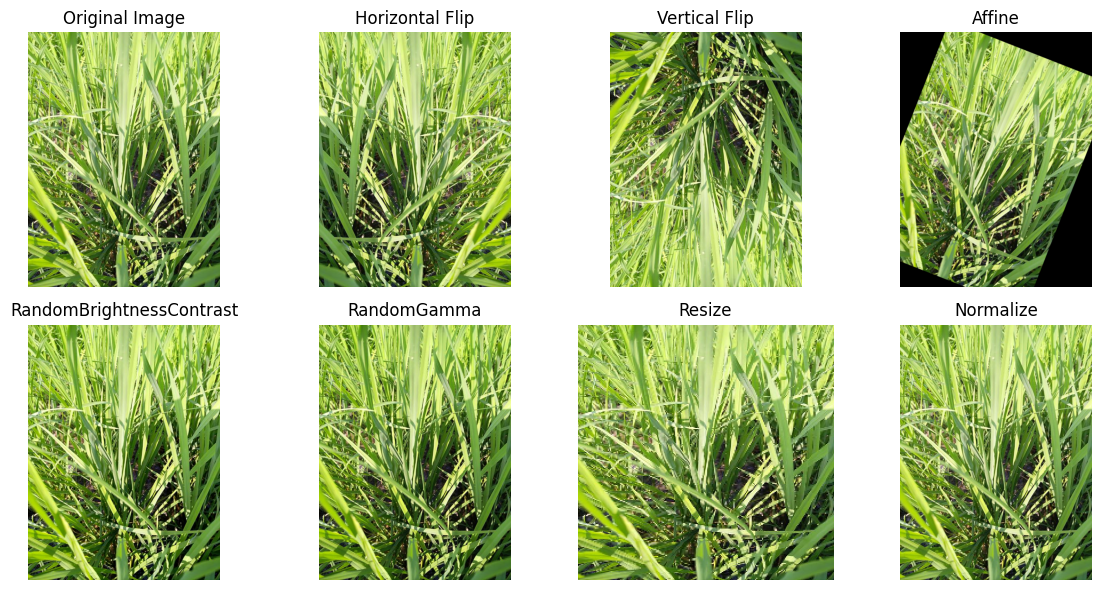

In [12]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 4, 1)
plt.title('Original Image')
plt.imshow(original_image)
plt.axis('off')

for idx, (name, transform) in enumerate(transformations, 2):
    row = 1 if idx <= 4 else 2
    col = idx if idx <= 4 else idx - 4
    
    if 'Normalize' in name:
        transformed = transform(image=original_image)
        transformed_image = transformed['image']
        transformed_image = denormalize(transformed_image)
    else:
        transformed = transform(image=original_image)
        transformed_image = transformed['image']

    plt.subplot(2, 4, col + (row - 1) * 4)
    plt.title(name)
    plt.imshow(transformed_image)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [45]:
mixup_fn = Mixup(
    mixup_alpha=0.7,
    cutmix_alpha=0.5,
    prob=1.0,
    switch_prob=0.5,
    mode="batch",
    label_smoothing=0.05,
    num_classes=len(class_map),
)

In [28]:
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

In [29]:
random_labels = random.sample(label_folders, 2)
label_path1 = os.path.join(dataset_path, random_labels[0])
label_path2 = os.path.join(dataset_path, random_labels[1])

image_files1 = [f for f in os.listdir(label_path1) if f.endswith('.jpg')]
image_files2 = [f for f in os.listdir(label_path2) if f.endswith('.jpg')]

random_image1 = random.choice(image_files1)
random_image2 = random.choice(image_files2)
image_path1 = os.path.join(label_path1, random_image1)
image_path2 = os.path.join(label_path2, random_image2)

In [30]:
image1 = cv2.imread(image_path1)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.imread(image_path2)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

In [31]:
image1_tensor = preprocess(image1)
image2_tensor = preprocess(image2)

In [32]:
batch_images = torch.stack([image1_tensor, image2_tensor])
batch_labels = torch.tensor([class_map[random_labels[0]], class_map[random_labels[1]]], dtype=torch.long)

In [46]:
augmented_images, _ = mixup_fn(batch_images, batch_labels)

augmented_image = denormalize(augmented_images[0])

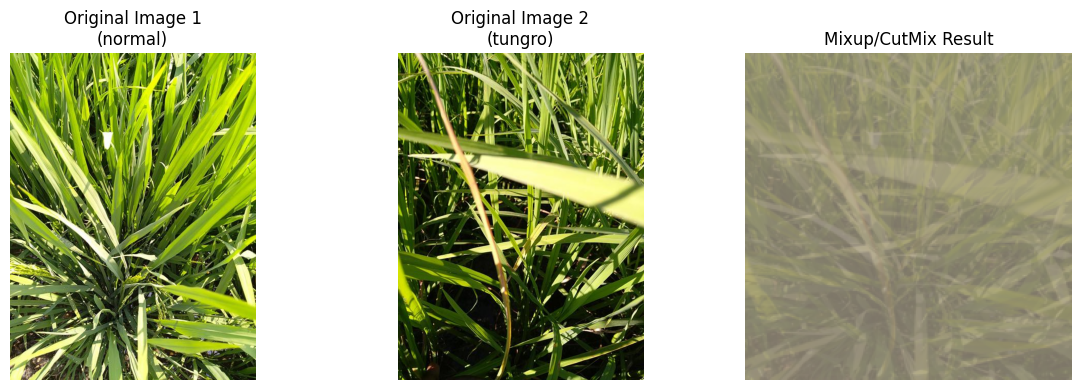

In [47]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title('Original Image 1\n({})'.format(random_labels[0]))
plt.imshow(image1)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Original Image 2\n({})'.format(random_labels[1]))
plt.imshow(image2)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Mixup/CutMix Result')
plt.imshow(augmented_image)
plt.axis('off')

plt.tight_layout()
plt.show()